In [1]:
import arviz as az
import graphviz
import numpy as np
import pandas as pd
import pymc3 as pm
import pyro
import pyro.distributions as dist
import pyro.poutine as poutine
import scipy.stats as stats
import torch
from IPython.display import display, Markdown
from pyro.infer import EmpiricalMarginal
from pyro.infer.mcmc import MCMC, NUTS
from torch.autograd import Variable
from torch.nn import functional as F

torch.manual_seed(0)
np.random.seed(0)

ALL_RESULTS = []
N_SAMPLES = 500 # PyMC3 defaults to 500 for each chain
N_WARM_UP = 700 # PyMC3 defaults to 500 for each chain

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
ERROR (theano.gpuarray): pygpu was configured but could not be imported or is too old (version 0.7 or higher required)
NoneType: None


# Introduction to Probabilistic Programming

## Sampling methods

- sampling is difficult even though we know PDF
- but possible
- even though our PDF-like function is not normalized

well-known algorithms:

- naive sampling
    - only for plain easy distributions
- Rejection sampling
    - rejects too many samples
    - takes much time to tune parameter
- Importance sampling
    - (?)
- MCMC (Markov Chain Monte Carlo)
    - Metropolis-Hastings algorithm (1953)
        - accepts all samples after burn-in phase
        - takes too much time to samples from high dimensional distributions
    - Gibbs Sampling (1984)
        - good for high dimensional distribution
        - needs to analyze conditional probabilities
    - Hamiltonian Monte Carlo sampling (1987)
        - fast
        - needs additional parameters to be tuned
    - NUTS (No U-Turn Sampler, 2011)
        - Hamiltonian Monte Carlo Method + auto tuning of step size and number of steps
        - does not use Metropolis acceptance
        - only for continuous parameters which have gradients

## Posterior probability

$$
P(\theta \vert D) = {{P(D \vert \theta)P(\theta)}\over{P(D)}}
$$

[Detailed derivation for MLE and MAP](https://wiseodd.github.io/techblog/2017/01/01/mle-vs-map/)

## MAP with sampling methods

1. build a hypothesis model as a Bayesian network
2. sample and find posterior distribution from PDFs
3. pick the modes of parameters from the posterior distribution

## Frameworks

- `PyMC3`
    - working on theano
- `Pyro`
    - working on PyTorch
- `TensorFlow probability`
    - too young
- `Stan`
- `Edward`

### github stars

![github star history of libraries](./github_star_history.png)

## Titanic example

### Preprocessing

#### Load titanic_train dataset

In [2]:
df = pd.read_csv('datasets/titanic_train_kaggle.csv')

#### Split

In [3]:
raw_train_data = df.sample(frac=0.8)
raw_test_data = df.drop(raw_train_data.index) # creates new pd.DataFrame object as always

#### Transform

In [4]:
def get_valid_values(series, min_category_counts=30):
        all_val_counts = series.dropna().value_counts()
        all_val_counts = all_val_counts[all_val_counts >= min_category_counts]
        return all_val_counts.index

class BinaryEncoding():
    """binary-string to one-hot"""
    
    min_category_counts = 30
    
    def __init__(self):
        self.mapping = {} # {field: {class1: 0.0, class2: 1.0}

    def fit(self, df):
        for col_name in df.columns:
            if not pd.api.types.is_string_dtype(df[col_name].dtype):
                continue
            unique_values = get_valid_values(df[col_name], min_category_counts=self.min_category_counts)

            if len(unique_values) != 2:
                continue
            for val in unique_values:
                self.mapping[col_name] = {unique_values[i]: float(i) for i in range(len(unique_values))}

    def transform(self, df):
        for col_name in self.mapping:
            df[col_name] = df[col_name].map(self.mapping[col_name])

class OneHotEncoding():
    """multi-class-string to one-hot"""
    prefix_sep = '!'
    min_category_counts = 30

    def __init__(self):
        self.column_mapping = {} # {field: {class1, class2, class3, ...}}

    def fit(self, df):
        for col_name in df.columns:
            if not pd.api.types.is_string_dtype(df[col_name].dtype):
                continue
            unique_values = get_valid_values(df[col_name], min_category_counts=self.min_category_counts)

            if len(unique_values) <= 2:
                continue
            self.column_mapping[col_name] = set(unique_values)

    def transform(self, df):
        column_names = set(self.column_mapping)
        for col_name in column_names:
            values = self.column_mapping[col_name]
            for val in values:
                new_col_name = "{}{}{}".format(col_name, self.prefix_sep, val)
                df[new_col_name] = (df[col_name] == val).astype('float64')
        df.drop(columns=list(column_names), inplace=True)
    
class Standardization():
    def __init__(self):
        self.mean = None
        self.std = None

    def fit(self, df):
        self.mean = df.mean()
        self.std = df.std()

    def transform(self, df):
        transform_columns = self.mean.index
        input_columns = set(df.columns)
        for col_name in transform_columns:
            if col_name in input_columns:
                df[col_name] = (df[col_name] - self.mean[col_name])/self.std[col_name] 

class Imputation():
    def __init__(self):
        self.mean = None

    def fit(self, df):
        self.mean = df.mean()

    def transform(self, df):
        for col_name in df.columns:
            if pd.api.types.is_numeric_dtype(df[col_name].dtype):
                df[col_name].fillna(self.mean[col_name], inplace=True)

class ColumnRemover():
    def __init__(self):
        self.column_names = set()

    def fit(self, df):
        for col_name in df.columns:
            if pd.api.types.is_numeric_dtype(df[col_name].dtype):
                self.column_names.add(col_name)
    def transform(self, df):
        for col_name in df.columns:
            if col_name not in self.column_names:
                df.drop(columns=col_name, inplace=True)
                
class FloatConverter():
    def __init__(self):
        self.column_names = set()

    def fit(self, df):
        for col_name in df.columns:
            if pd.api.types.is_numeric_dtype(df[col_name].dtype):
                self.column_names.add(col_name)
    def transform(self, df):
        for col_name in df.columns:
            if col_name in self.column_names:
                df[col_name] = df[col_name].astype('float64')

class Chain():
    def __init__(self, transforms):
        self.transforms = transforms

    def fit_transform(self, df):
        for tr in self.transforms:
            tr.fit(df)
            tr.transform(df)
    
    def transform(self, df):
        for tr in self.transforms:
            tr.transform(df)

In [5]:
target_column_name = 'Survived'
fields_to_ignore = ["Name", "PassengerId", "Ticket"] + [target_column_name]
input_transform_chain = Chain([BinaryEncoding(), OneHotEncoding(), Imputation(), Standardization(), ColumnRemover(), FloatConverter()])
train_data_x = raw_train_data.copy().drop(columns=fields_to_ignore)
input_transform_chain.fit_transform(train_data_x)

label_transform = FloatConverter()
train_data_y = raw_train_data[[target_column_name]].copy()
label_transform.fit(train_data_y)
label_transform.transform(train_data_y)

test_data_x = raw_test_data.copy().drop(columns=fields_to_ignore)
input_transform_chain.transform(test_data_x)

test_data_y = raw_test_data[[target_column_name]].copy()
label_transform.transform(test_data_y)

n_features = len(train_data_x.columns)

In [6]:
train_data_x

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked!Q,Embarked!C,Embarked!S
495,0.809817,-0.732042,5.413503e-16,-0.477709,-0.465786,-0.338237,-0.302910,2.136329,-1.663911
648,0.809817,-0.732042,5.413503e-16,-0.477709,-0.465786,-0.470320,-0.302910,-0.467436,0.600151
278,0.809817,-0.732042,-1.714644e+00,3.244764,0.782731,-0.057817,3.296675,-0.467436,-1.663911
31,-1.586031,1.364126,5.413503e-16,0.452910,-0.465786,2.186730,-0.302910,2.136329,-1.663911
255,0.809817,1.364126,-3.850224e-02,-0.477709,2.031248,-0.323180,-0.302910,2.136329,-1.663911
...,...,...,...,...,...,...,...,...,...
25,0.809817,1.364126,6.471923e-01,0.452910,5.776800,-0.014559,-0.302910,-0.467436,0.600151
110,-1.586031,-0.732042,1.332887e+00,-0.477709,-0.465786,0.379541,-0.302910,-0.467436,0.600151
149,-0.388107,-0.732042,9.519454e-01,-0.477709,-0.465786,-0.366119,-0.302910,-0.467436,0.600151
152,0.809817,-0.732042,1.980487e+00,-0.477709,-0.465786,-0.460760,-0.302910,-0.467436,0.600151


In [7]:
train_data_y

,Survived
495,0.0
648,0.0
278,0.0
31,1.0
255,1.0
...,...
25,1.0
110,0.0
149,0.0
152,0.0


### Plain logistic regression with PyTorch

In [8]:
x_train = torch.Tensor(train_data_x.values)
y_train = torch.Tensor(train_data_y.values)
x_test = torch.Tensor(test_data_x.values)
y_test = test_data_y.values

class LogisticRegression(torch.nn.Module):
    def __init__(self, n_input_fields):
        super().__init__()
        n_output_fields = 1
        self.linear = torch.nn.Linear(n_input_fields, n_output_fields)

    def forward(self, x):
        y_pred = F.sigmoid(self.linear(x))
        return y_pred

model = LogisticRegression(x_train.shape[1])

criterion = torch.nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
for epoch in range(400):
    model.train()
    optimizer.zero_grad()    # Forward pass
    y_pred = model(x_train)    # Compute Loss
    loss = criterion(y_pred, y_train)    # Backward pass
    loss.backward()
    optimizer.step()

/home/hotohoto/playground/pp_research/venv/lib/python3.6/site-packages/torch/nn/functional.py:1350: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


In [9]:
y_pred = model(x_test)
result = ["PyTorch", "MLE"]

print("predicted y values:")
for i in range(10):
    print(i, y_pred.data[i][0])

y_pred = y_pred.detach().numpy()
y_pred = (y_pred >= 0.5).astype(np.float64)
accuracy_test = np.mean(np.equal(y_pred, y_test))
print("accuracy:", accuracy_test)
result.append(accuracy_test)

print("weights:")
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name, param.data)
        result.append(param.data)
        
ALL_RESULTS.append(result)

predicted y values:
0 tensor(0.8022)
1 tensor(0.5523)
2 tensor(0.7251)
3 tensor(0.4584)
4 tensor(0.5806)
5 tensor(0.5805)
6 tensor(0.4906)
7 tensor(0.5931)
8 tensor(0.4913)
9 tensor(0.8257)
accuracy: 0.7921348314606742
weights:
linear.weight tensor([[-0.1916,  0.4805, -0.2604, -0.2116, -0.0432,  0.2063,  0.0040,  0.2541,
         -0.0301]])
linear.bias tensor([-0.1452])


### Bayesian model definition

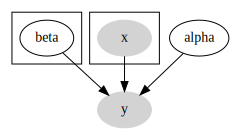

In [10]:
# requirements: install `graphviz` in your system first. e.g. `sudo apt install graphviz`
graphviz.Source("""
digraph {
  subgraph cluster_beta {
    beta;
  }
  
  subgraph cluster_x {
    x [style=filled, color=lightgrey];
  }
  
  alpha -> y;
  beta -> y;
  x -> y;
  y [style=filled, color=lightgrey];
}
""")

$$
\beta \sim N(0, 1) \\
\alpha \sim N(0, 10) \\
X \sim Unif(-10, 10) \\
\text{y} \sim Bern(sigmoid(\text{x} \cdot \beta + \alpha))) \\
$$

### MAP with PyMC3

In [11]:
x_train = train_data_x.values
y_train = train_data_y.values
x_test = test_data_x.values
y_test = test_data_y.values

In [12]:
basic_model = pm.Model()

with basic_model:
    x_obs = pm.Uniform(
        'x_obs',
        lower=-10,
        upper=10,
        observed=x_train,
        shape=(1, n_features)
    )

    beta = pm.Normal(
        'beta',
        mu=0,
        sigma=1,
        shape=(n_features, 1)
    )

    alpha = pm.Normal(
        'alpha',
        mu=0,
        sigma=10
    )

    p = pm.math.sigmoid(pm.math.dot(x_obs, beta) + alpha)
    y_obs = pm.Bernoulli('y_obs', p=p, observed=y_train)
    
    map_estimate = pm.find_MAP()

/home/hotohoto/playground/pp_research/venv/lib/python3.6/site-packages/pymc3/tuning/starting.py:61: UserWarning: find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.
  warnings.warn('find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.')
logp = -19,553, ||grad|| = 0.13214: 100%|██████████| 21/21 [00:00<00:00, 1391.28it/s]  


In [13]:
for name, node in map_estimate.items():
    print('{:<20} {}'.format(name, node))

print("weights:")
beta = map_estimate['beta']
alpha = map_estimate['alpha']
def sigmoid(x):
    return 1.0 / (1.0 + np.e**(-x))

y_pred = sigmoid(x_test@beta + alpha)
y_pred = (y_pred >= 0.5).astype(np.float64)
accuracy_test = np.mean(np.equal(y_pred, y_test))
print("accuracy:", accuracy_test)

ALL_RESULTS.append(["PyMC3", "MAP", accuracy_test, beta, alpha])

beta                 [[-0.81084257]
 [ 1.22136436]
 [-0.47974153]
 [-0.36723723]
 [-0.06018706]
 [ 0.14300001]
 [-0.04508642]
 [ 0.04138269]
 [-0.17649957]]
alpha                -0.7420384660904997
weights:
accuracy: 0.8033707865168539


In [14]:
with basic_model:
    trace = pm.sample(N_SAMPLES//4, tune=N_WARM_UP)

Only 125 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta]
Sampling 4 chains: 100%|██████████| 3300/3300 [00:10<00:00, 306.50draws/s]
The acceptance probability does not match the target. It is 0.8866474905970004, but should be close to 0.8. Try to increase the number of tuning steps.


In [15]:
summary = pm.stats.summary(trace)
summary

/home/hotohoto/playground/pp_research/venv/lib/python3.6/site-packages/pymc3/stats.py:991: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.
  axis=1, join_axes=[dforg.index])


,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
beta__0_0,-0.819875,0.127280,0.006008,-1.077936,-0.584838,404.347687,1.001222
beta__1_0,1.240879,0.104274,0.004115,1.056743,1.457712,602.139233,0.998218
beta__2_0,-0.497032,0.108948,0.005011,-0.713736,-0.291164,472.662166,0.998302
beta__3_0,-0.379361,0.125942,0.006058,-0.592931,-0.112845,485.674681,1.003785
beta__4_0,-0.079203,0.103200,0.005015,-0.277281,0.102700,481.857828,1.006572
beta__5_0,0.170173,0.141386,0.006122,-0.107032,0.445652,501.127120,0.998688
beta__6_0,-0.062336,0.409151,0.021384,-0.964074,0.681199,319.657730,1.003287
beta__7_0,0.023651,0.555536,0.028491,-1.068014,1.072748,359.670828,1.002746
beta__8_0,-0.202833,0.634157,0.033084,-1.453040,0.987992,340.694242,1.003333
alpha,-0.752753,0.104653,0.004989,-0.931789,-0.551121,421.888068,0.997206


In [16]:
# using posterior mean
beta = np.reshape(summary['mean'][:-1].values, (n_features, 1))
alpha = summary['mean'][-1]

print("weights:")
print('beta')
print(beta)
print('alpha')
print(alpha)

y_pred = sigmoid(x_test@beta + alpha)
y_pred = (y_pred >= 0.5).astype(np.float64)
accuracy_test = np.mean(np.equal(y_pred, y_test))

print("accuracy:", accuracy_test)

ALL_RESULTS.append(["PyMC3", "Posterior Mean", float(accuracy_test), beta, alpha])

weights:
beta
[[-0.81987542]
 [ 1.24087866]
 [-0.4970318 ]
 [-0.3793614 ]
 [-0.07920335]
 [ 0.17017337]
 [-0.06233572]
 [ 0.02365072]
 [-0.2028331 ]]
alpha
-0.7527533468143365
accuracy: 0.8033707865168539


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f8696cfba20>,
      dtype=object)

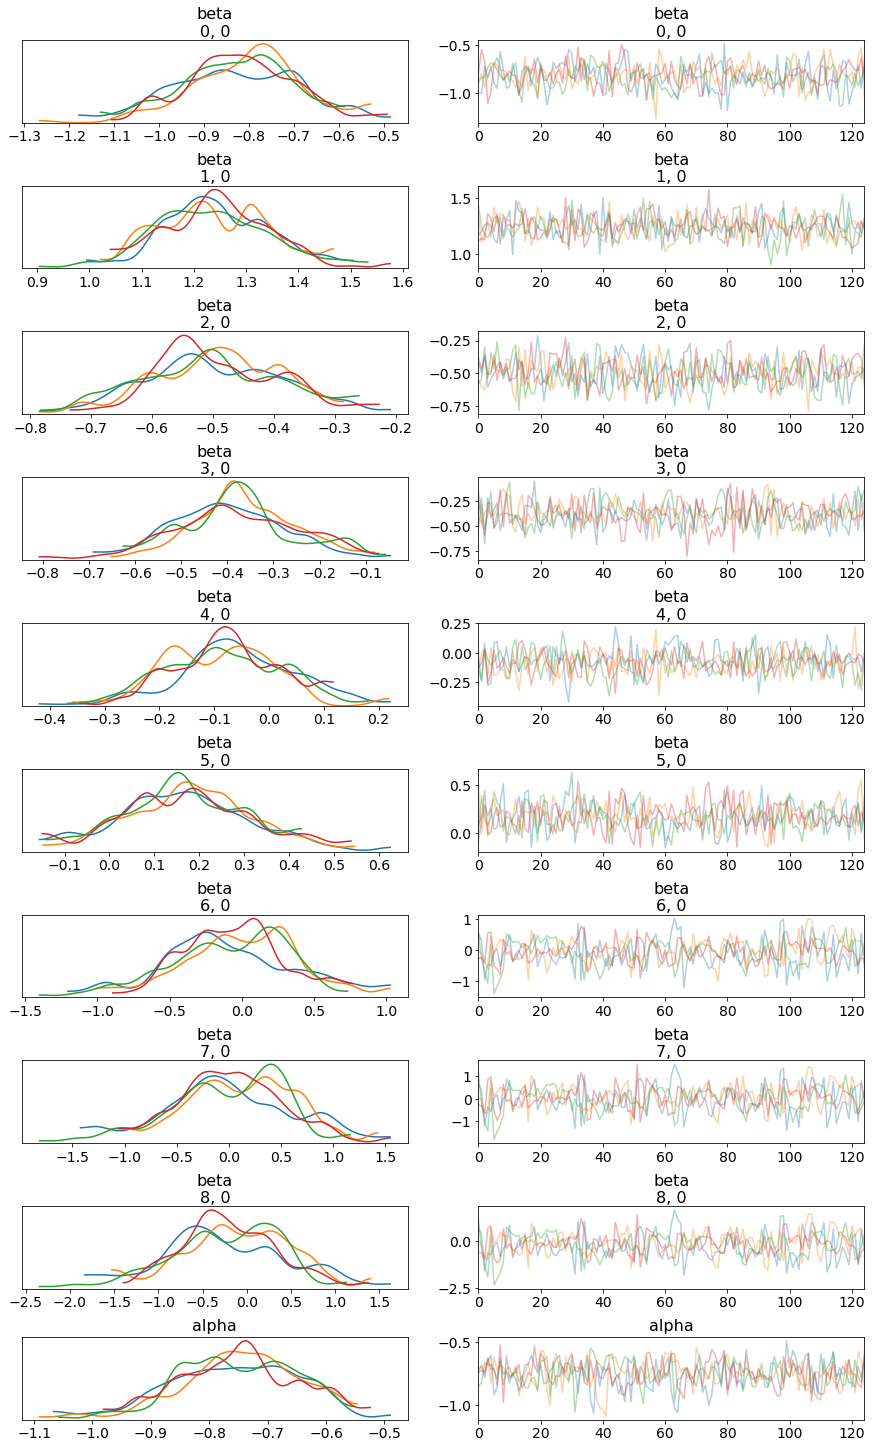

In [17]:
pm.plots.traceplot(trace)

(<Figure size 432x648 with 1 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f86933d8898>],
       dtype=object))

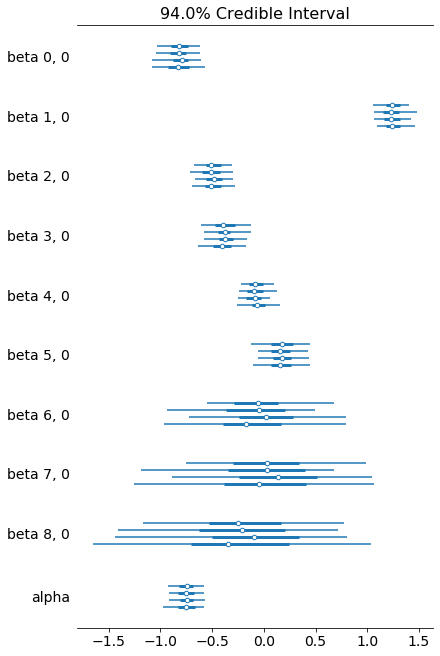

In [18]:
pm.plots.forestplot(trace)

### MAP with Pyro

In [19]:
x_train = torch.Tensor(train_data_x.values)
y_train = torch.Tensor(train_data_y.values)
x_test = test_data_x.values
y_test = test_data_y.values

def model(x_train, y_train):
    x_obs = pyro.sample('x_obs', dist.Uniform(-10, 10), obs=x_train)
    beta = pyro.sample('beta', dist.Normal(torch.zeros(n_features, 1), torch.ones(1)))
    alpha = pyro.sample('alpha', dist.Normal(0, 10))
    return pyro.sample("y_obs", dist.Bernoulli(torch.sigmoid(x_obs@beta + alpha)), obs=y_train)

nuts_kernel = NUTS(model)
mcmc_sampler = MCMC(nuts_kernel, num_samples=N_SAMPLES, warmup_steps=N_WARM_UP)
posterior = mcmc_sampler.run(x_train, y_train)

Sample: 100%|██████████| 1200/1200 [01:11<00:00, 16.82it/s, step size=1.11e-01, acc. prob=0.934]


In [20]:
def map_sites(func, posterior, sites):
    marginal = posterior.marginal(sites)
    site_stats = {}
    for site in sites:
        marginal_site = marginal.support(flatten=True)[site]
        site_stats[site] = func(marginal_site.numpy(), site)
    return site_stats

def get_mode(array, name):
    if len(array.shape) == 1:
        names = [name]
    else:
        names = ["{}[{}]".format(name, i) for i in range(array.shape[1])]
    array_ = array.reshape(array.shape[0],-1)
    
    modes = []

    for i in range(array_.shape[1]):
        values =array_[:, i]
        kernel = stats.gaussian_kde(values)
        height = kernel.pdf(values)
        mode_value = values[np.argmax(height)]
        modes.append(mode_value)
    
    return modes

# using estimated mode values

sites = ["beta", "alpha"]
modes = map_sites(get_mode, posterior, sites)
print(modes)

beta = np.reshape(np.array(modes['beta']), (n_features, 1))
alpha = np.array(modes['alpha'])

y_pred = sigmoid(x_test@beta + alpha)
y_pred = (y_pred >= 0.5).astype(np.float64)
accuracy_test = np.mean(np.equal(y_pred, y_test))
print("accuracy:", accuracy_test)

ALL_RESULTS.append(["Pyro", "MAP", accuracy_test, beta, alpha])

{'beta': [-0.8091466, 1.2412101, -0.46764177, -0.41007835, -0.09295544, 0.13153544, -0.052039843, 0.16449566, -0.009230375], 'alpha': [-0.7300333]}
accuracy: 0.8089887640449438


In [21]:
def get_site_stats(array, name):
    if len(array.shape) == 1:
        names = [name]
    else:
        names = ["{}[{}]".format(name, i) for i in range(array.shape[1])]
    print(names, array.shape)
    array_ = array.reshape(array.shape[0],-1)
    df = pd.DataFrame(array_, columns=names).transpose()
    return df.apply(pd.Series.describe, axis=1)[["mean", "std", "25%", "50%", "75%"]]


sites = ["beta", "alpha"]
df_summary = pd.concat([s for s in map_sites(get_site_stats, posterior, sites).values()])
print(df_summary)

['beta[0]', 'beta[1]', 'beta[2]', 'beta[3]', 'beta[4]', 'beta[5]', 'beta[6]', 'beta[7]', 'beta[8]'] (500, 9, 1)
['alpha'] (500,)
             mean       std       25%       50%       75%
beta[0] -0.824687  0.146053 -0.919178 -0.819947 -0.733288
beta[1]  1.247325  0.107828  1.173641  1.245197  1.317231
beta[2] -0.491600  0.123176 -0.574436 -0.485570 -0.410450
beta[3] -0.387881  0.138758 -0.479751 -0.389397 -0.291010
beta[4] -0.067649  0.108442 -0.144563 -0.074188  0.007530
beta[5]  0.158172  0.136276  0.062575  0.149061  0.253914
beta[6] -0.081665  0.388595 -0.350960 -0.070865  0.202719
beta[7] -0.000461  0.536979 -0.387304  0.026394  0.390915
beta[8] -0.228480  0.612655 -0.669730 -0.212337  0.215509
alpha   -0.749950  0.098752 -0.821242 -0.748509 -0.682833


In [22]:
beta = np.reshape(df_summary['mean'][:-1].values, (n_features, 1))
alpha = df_summary['mean'][-1]

y_pred = sigmoid(x_test@beta + alpha)
y_pred = (y_pred >= 0.5).astype(np.float64)
accuracy_test = np.mean(np.equal(y_pred, y_test))
print("accuracy:", accuracy_test)

ALL_RESULTS.append(["Pyro", "Posterior Mean", accuracy_test, beta, alpha])

accuracy: 0.8033707865168539


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f86913e42e8>,
      dtype=object)

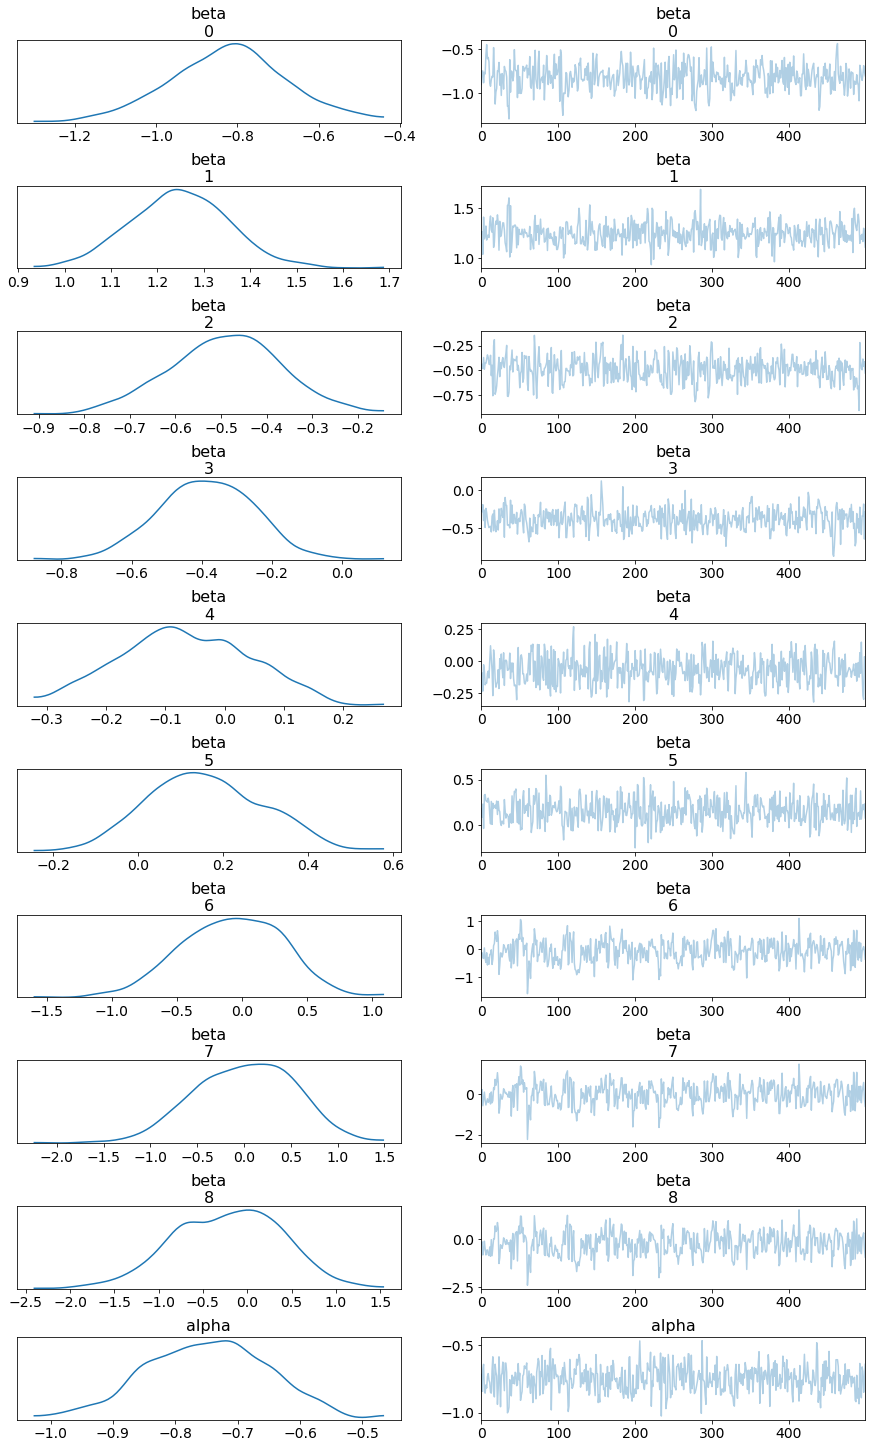

In [23]:
data = az.convert_to_inference_data(posterior)
az.plot_trace(data)

(<Figure size 432x432 with 1 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f8680a27f28>],
       dtype=object))

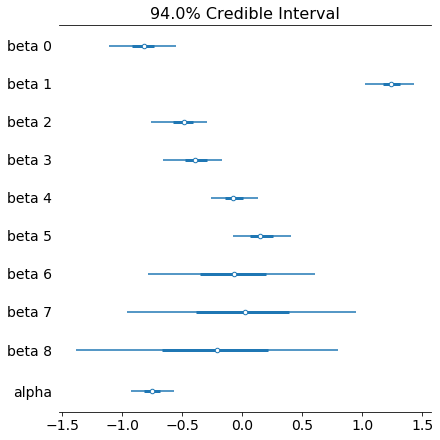

In [24]:
az.plot_forest(data)

## Results 

In [25]:
markdown = "|Framework|Estimator|Test Accuracy|beta(weights)|alpha(bias)|\n"
markdown += "|-|-|-|-|-|\n"

def value_checker(val):
    if isinstance(val, np.float64):
        return str(val)
    if isinstance(val, torch.Tensor):
        return str(val.tolist())
    if isinstance(val, np.ndarray):
        return str(val.tolist())
    return str(val)

for result in ALL_RESULTS:
    result_ = list(map(value_checker, result))
    markdown += "|" + '|'.join(result_) + "|\n"

display(Markdown(markdown))

|Framework|Estimator|Test Accuracy|beta(weights)|alpha(bias)|
|-|-|-|-|-|
|PyTorch|MLE|0.7921348314606742|[[-0.1915731132030487, 0.48054519295692444, -0.2604350447654724, -0.21163827180862427, -0.043249573558568954, 0.20626457035541534, 0.004018059466034174, 0.25409847497940063, -0.030102478340268135]]|[-0.14523153007030487]|
|PyMC3|MAP|0.8033707865168539|[[-0.8108425657142261], [1.221364363247121], [-0.4797415295635797], [-0.36723722735417175], [-0.060187064796941143], [0.1430000127089287], [-0.04508641926025794], [0.041382687437798465], [-0.1764995721207729]]|-0.7420384660904997|
|PyMC3|Posterior Mean|0.8033707865168539|[[-0.8198754185181085], [1.240878664259657], [-0.49703180150554277], [-0.3793614034360163], [-0.07920335135864788], [0.17017337476383368], [-0.06233572240791937], [0.02365072142309425], [-0.20283309872697639]]|-0.7527533468143365|
|Pyro|MAP|0.8089887640449438|[[-0.8091465830802917], [1.2412101030349731], [-0.46764177083969116], [-0.41007834672927856], [-0.09295544028282166], [0.13153544068336487], [-0.052039843052625656], [0.16449566185474396], [-0.009230375289916992]]|[-0.730033278465271]|
|Pyro|Posterior Mean|0.8033707865168539|[[-0.8246865272521973], [1.2473249435424805], [-0.4915999472141266], [-0.3878810405731201], [-0.06764896959066391], [0.1581716686487198], [-0.08166541904211044], [-0.0004609489405993372], [-0.22847963869571686]]|-0.7499504685401917|


## Questions

- Where is independence of i.i.d applied to?
  - Isn't it conditional independence?
- Is there a distribution which is a continous version of Bernoulli distribution?
  - to compare the accuracy valus more precisely

## References

- [Github star chart](https://star-history.t9t.io/#pymc-devs/pymc3&pyro-ppl/pyro&tensorflow/probability&stan-dev/stan&blei-lab/edward) (use chrome)
- [PyMC3](https://docs.pymc.io/)
- [Pyro](https://pyro.ai/)
- [Faster estimation of Bayesian models in ecology using Hamiltonian Monte Carlo](https://besjournals.onlinelibrary.wiley.com/doi/full/10.1111/2041-210X.12681)
- [MAP lecture note, Standford CS109](https://web.stanford.edu/class/archive/cs/cs109/cs109.1166/ppt/22-MAP.pdf)

## Appendix

### Bayesian network

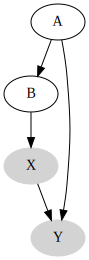

In [26]:
# requirements: install `graphviz` in your system first. e.g. `sudo apt install graphviz`
graphviz.Source("""
digraph {
  
  A -> B;
  A -> Y;
  B -> X;
  X -> Y;
  X,Y [style=filled, color=lightgrey];
}
""")

- We can find simplified joint probability easily

$$
P(A=a,B=b,C=c,X=x,Y=y) \\
= P(a,b,x,y) \\
= P(a)P(b \vert a)P(x \vert b)P(y \vert x,a)
$$